In [1]:
import os

import nltk

from cltk.corpus.latin import latinlibrary

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS

import matplotlib.pyplot as plt

import pickle

from pprint import pprint

In [2]:
TextArray = pickle.load(open("./data/text_array.p", "rb"))

In [3]:
print(f'{TextArray[1][0]},\n{TextArray[1][1]},\n{TextArray[1][2][:1000]}')

prose,
caesar/bc1.txt,
gratiam sequantur ut superioribus fecerint temporibus se sibi consilium capturum neque senatus auctoritati obtemperaturum habere se quoque ad caesaris gratiam atque amicitiam receptum in eandem sententiam loquitur scipio pompeio esse in animo rei publicae non deesse si senatus sequatur si cunctetur atque agat lenius nequiquam eius auxilium si postea uelit senatum imploraturum
haec scipionis oratio quod senatus in urbe habebatur pompeiusque aberat ex ipsius ore pompei mitti uidebatur dixerat aliquis leniorem sententiam ut primo m marcellus ingressus in eam orationem non oportere ante de ea re ad senatum referri quam dilectus tota italia habiti et exercitus conscripti essent quo praesidio tuto et libere senatus quae uellet decernere auderet ut m calidius qui censebat ut pompeius in suas prouincias proficisceretur ne qua esset armorum causa timere caesarem ereptis ab eo duabus legionibus ne ad eius periculum reseruare et retinere eas ad urbem pompeius uideretur ut m

In [4]:
labels = [type for type, _, _ in TextArray]
texts = [text for _, _, text in TextArray]
titles = [title.replace('/', '_').replace('.txt','') for _, title, _ in TextArray]

In [5]:
vectorizer = CountVectorizer(input='content')
dtm = vectorizer.fit_transform(texts)
vocab = np.array(vectorizer.get_feature_names())
dtm = dtm.toarray()

In [7]:
dtm

array([[48,  0,  0, ...,  0,  0,  0],
       [88,  0,  0, ...,  0,  0,  0],
       [40,  0,  0, ...,  0,  0,  0],
       ...,
       [11,  0,  0, ...,  0,  0,  0],
       [13,  0,  0, ...,  0,  0,  0],
       [15,  0,  0, ...,  0,  0,  0]], dtype=int64)

In [8]:
dtm.shape

(137, 87449)

In [48]:
text_array_df = pd.DataFrame(dtm, columns=vocab, index=titles)
text_array_df.iloc[[0,25,50,100,123],:10]

,ab,abaci,abacis,abaco,abacorum,abacta,abactae,abactas,abacti,abacum
caesar_alex,48,0,0,0,0,0,0,0,0,0
livy_liv.24,120,0,0,0,0,0,0,0,1,0
vergil_aen11,13,0,0,0,0,0,0,0,1,0
ovid_ovid.her19,2,0,0,0,0,0,0,0,0,0
ovid_ovid.met6,12,0,0,0,0,0,0,0,0,0


In [49]:
rates = 1000 * dtm / np.sum(dtm, axis=1, keepdims=True)

In [52]:
rates_df = pd.DataFrame(rates, columns=vocab, index=titles)
rates_df.iloc[[0,25,50,100,125,136],:10]

,ab,abaci,abacis,abaco,abacorum,abacta,abactae,abactas,abacti,abacum
caesar_alex,4.725340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
livy_liv.24,8.702589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072522,0.0
vergil_aen11,2.299257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.176866,0.0
ovid_ovid.her19,1.811594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
ovid_ovid.met8,3.755163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
ovid_ovid.tristia5,3.236246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [53]:
prose_indices, verse_indices = [], []

for i, item in enumerate(TextArray):
    if item[0] == "prose":
        prose_indices.append(i)
    elif item[0] == "verse":
        verse_indices.append(i)

In [54]:
from sklearn.feature_selection import chi2
keyness, _ = chi2(dtm, labels)
ranking = np.argsort(keyness)[::-1]

In [55]:
ranking[0:10]

array([38915,  1271, 28280, 19762, 87047, 28677, 66836, 67035,     0,
         523])

In [56]:
vocab[ranking][0:10]

array(['in', 'ad', 'et', 'cum', 'ut', 'ex', 'qui', 'quod', 'ab', 'ac'],
      dtype='<U22')

In [69]:
dist = 1 - cosine_similarity(dtm)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

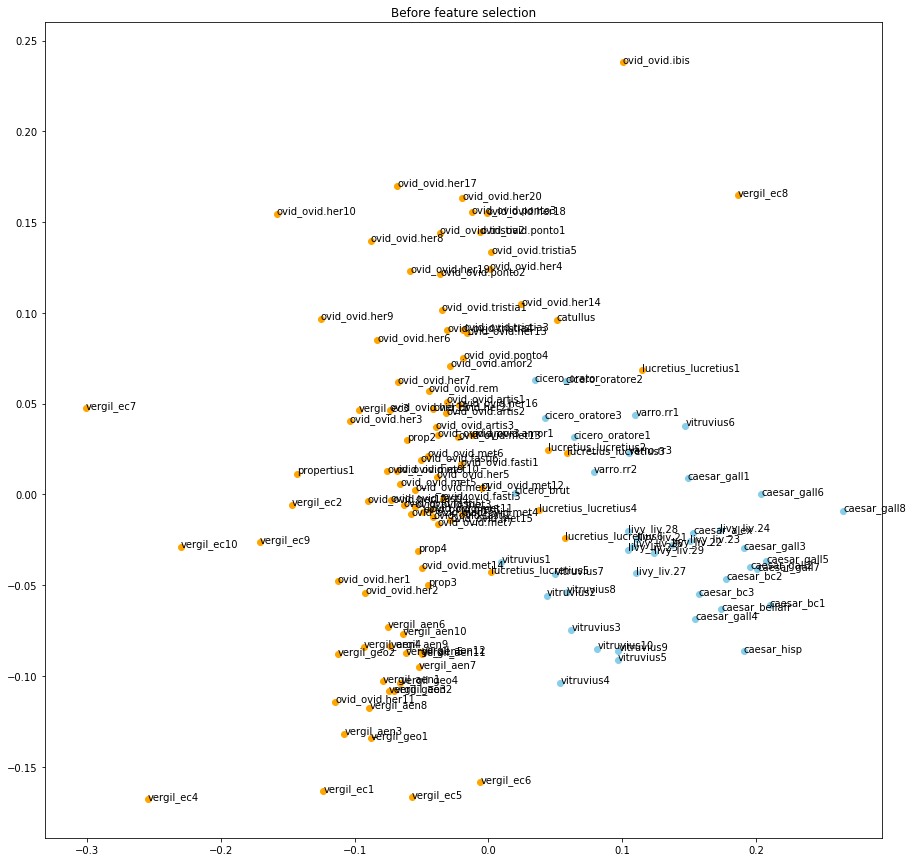

In [72]:
xs, ys = pos[:, 0], pos[:, 1]

names = [os.path.basename(fn).replace('.txt', '') for fn in titles]

plt.figure(figsize=(15,15))
for x, y, title, label in zip(xs, ys, titles, labels):
    color = 'orange' if label == 'verse' else 'skyblue'
    plt.scatter(x, y, c=color)
    plt.text(x, y, title)


plt.title("Before feature selection")
plt.show()

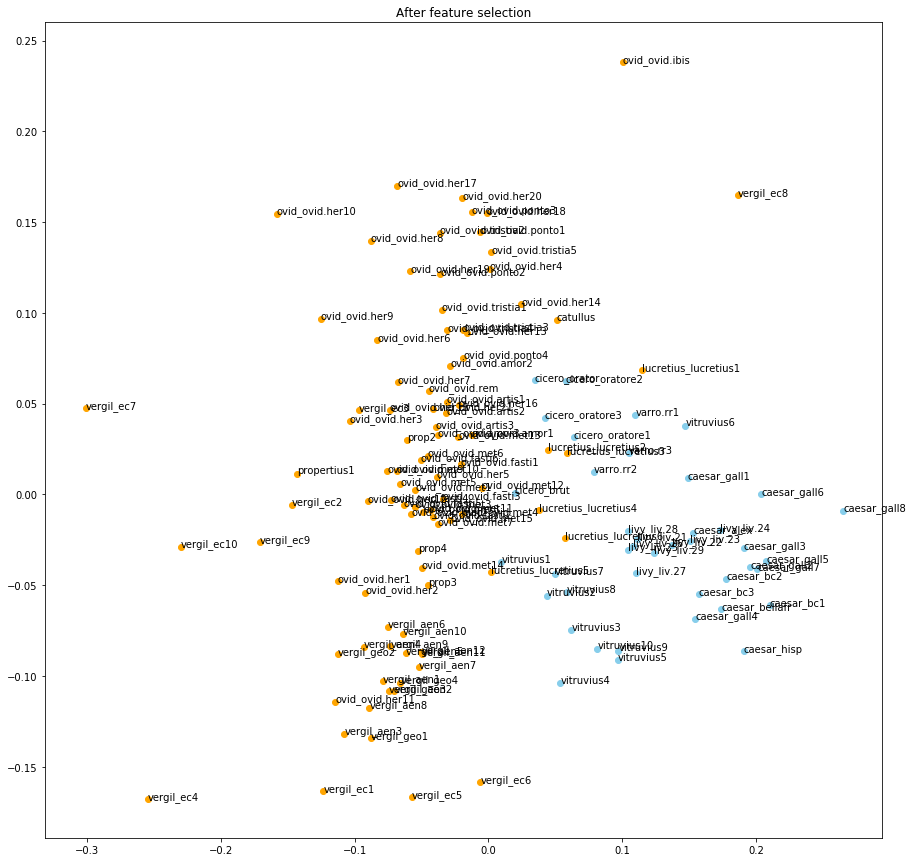

In [73]:
selected = np.argsort(keyness)[::-1][:50]
dtm_chi2 = dtm[:, selected]
dist = 1 - cosine_similarity(dtm_chi2)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

plt.figure(figsize=(15,15))
for x, y, title, label in zip(xs, ys, titles, labels):
    color = 'orange' if label == 'verse' else 'skyblue'
    plt.scatter(x, y, c=color)
    plt.text(x, y, title)

plt.title("After feature selection")
plt.show()

In [74]:
text_array_df.iloc[:10,selected[-10:]]

,re,hostium,caesar,quo,castris,his,essent,uti,quidem,omnium
caesar_alex,12,19,40,51,21,15,15,7,5,11
caesar_bc1,21,6,67,26,37,35,6,12,2,21
caesar_bc2,9,16,10,12,13,14,6,6,10,13
caesar_bc3,20,4,89,34,48,56,21,16,5,18
caesar_bellafr,18,45,87,45,43,20,15,18,2,4
caesar_gall1,12,13,42,18,24,30,12,25,7,10
caesar_gall2,7,10,23,10,17,23,1,6,2,5
caesar_gall3,6,10,8,10,9,21,4,4,5,5
caesar_gall4,6,7,34,9,10,26,6,10,3,0
caesar_gall5,16,15,30,15,12,25,3,8,7,7


In [75]:
text_array_df.iloc[-10:,selected[-10:]]

,re,hostium,caesar,quo,castris,his,essent,uti,quidem,omnium
ovid_ovid.ponto1,0,0,4,10,0,3,0,2,1,0
ovid_ovid.ponto2,0,0,5,8,0,3,0,1,5,0
ovid_ovid.ponto3,1,0,3,5,1,7,0,3,4,0
ovid_ovid.ponto4,1,0,5,8,0,5,0,0,3,0
ovid_ovid.rem,0,0,0,9,0,3,0,2,1,0
ovid_ovid.tristia1,1,0,6,10,0,7,0,1,3,0
ovid_ovid.tristia2,0,0,6,6,1,4,1,2,4,0
ovid_ovid.tristia3,0,0,4,9,0,3,0,0,2,0
ovid_ovid.tristia4,0,0,5,15,0,2,0,0,2,0
ovid_ovid.tristia5,0,0,2,10,0,2,0,0,1,0


In [76]:
text_array_df.loc[:,['uxor','coniunx']]

,uxor,coniunx
caesar_alex,0,0
caesar_bc1,0,0
caesar_bc2,0,0
caesar_bc3,0,0
caesar_bellafr,0,0
caesar_gall1,0,0
caesar_gall2,0,0
caesar_gall3,0,0
caesar_gall4,0,0
caesar_gall5,0,0


In [77]:
prose_index = [i for i, item in enumerate(TextArray) if item[0] == 'prose']
verse_index = [i for i, item in enumerate(TextArray) if item[0] == 'verse']

In [78]:
p_sum = text_array_df.iloc[prose_index].sum().tolist()
v_sum = text_array_df.iloc[verse_index].sum().tolist()

In [79]:
type_df = pd.DataFrame(list(zip(p_sum, v_sum)), columns = ['prose', 'verse'], index=vocab)

In [80]:
type_df['poeticness'] = type_df['verse'] / (type_df['prose'] + type_df['verse'])

In [81]:
from sklearn.preprocessing import minmax_scale
type_df['keyness_scaled'] = minmax_scale(keyness)

In [83]:
type_df.sort_values(['keyness_scaled'], ascending=[0])[:10]

,prose,verse,poeticness,keyness_scaled
in,11266,4946,0.305083,1.000000
ad,5946,1465,0.197679,0.739005
et,11919,9551,0.444853,0.553912
cum,5309,2008,0.274429,0.523977
ut,4621,1893,0.290605,0.431745
ex,3125,596,0.160172,0.428441
qui,2953,1129,0.276580,0.289373
quod,3344,1521,0.312641,0.288730
ab,2438,836,0.255345,0.255915
ac,1815,349,0.161275,0.248150


In [84]:
type_df.loc['coniunx']

prose               2.000000
verse             164.000000
poeticness          0.987952
keyness_scaled      0.005396
Name: coniunx, dtype: float64

In [85]:
type_df.loc['uxor']

prose              9.000000
verse             46.000000
poeticness         0.836364
keyness_scaled     0.000399
Name: uxor, dtype: float64

In [86]:
type_df.loc['eis']

prose             347.000000
verse               1.000000
poeticness          0.002874
keyness_scaled      0.066782
Name: eis, dtype: float64

In [88]:
type_df.loc['et']

prose             11919.000000
verse              9551.000000
poeticness            0.444853
keyness_scaled        0.553912
Name: et, dtype: float64

## Mapping 'poeticness' in narrative space

In [89]:
# Script for preprocessing texts

import html
import re
import string
from cltk.stem.latin.j_v import JVReplacer

def preprocess(text):
    
    replacer = JVReplacer()
    
    text = html.unescape(text) # Handle html entities
    text = re.sub(r'&nbsp;?', ' ',text) #&nbsp; stripped incorrectly in corpus?
    text = re.sub(r'\x00',' ',text) #Another space problem?
        
    text = text.lower()
    text = replacer.replace(text) #Normalize u/v & i/j    
    
    punctuation ="\"#$%&\'()*+,-/:;<=>@[\]^_`{|}~.?!«»—"
    translator = str.maketrans({key: " " for key in punctuation})
    text = text.translate(translator)
    
    translator = str.maketrans({key: " " for key in '0123456789'})
    text = text.translate(translator)
    
    text = re.sub('[ ]+',' ', text) # Remove double spaces
    text = re.sub('\s+\n+\s+','\n', text) # Remove double lines and trim spaces around new lines
    
    return text.strip()

In [90]:
odes_tokens = preprocess("""Ne forte credas interitura quae
longe sonantem natus ad Aufidum
non ante volgatas per artis
verba loquor socianda chordis:
non, si priores Maeonius tenet
sedes Homerus, Pindaricae latent
Ceaeque et Alcaei minaces
Stesichorique graves Camenae

nec siquid olim lusit Anacreon
delevit aetas; spirat adhuc amor
vivuntque conmissi calores
Aeoliae fidibus puellae.

non sola comptos arsit adulteri
crinis et aurum vestibus inlitum
mirata regalisque cultus
et comites Helene Lacaena

primusve Teucer tela Cydonio
direxit arcu; non semel Ilios
vexata; non pugnavit ingens
Idomeneus Sthenelusve solus

dicenda Musis proelia; non ferox
Hector vel acer Deiphobus gravis
excepit ictus pro pudicis
coniugibus puerisque primus.

vixere fortes ante Agamemnona
multi; sed omnes inlacrimabiles
urgentur ignotique longa
nocte, carent quia vate sacro.

paullum sepultae distat inertiae
celata virtus. non ego te meis
chartis inornatum silebo,
totve tuos patiar labores

inpune, Lolli, carpere lividas
obliviones. est animus tibi
rerumque prudens et secundis
temporibus dubiisque rectus,

vindex avarae fraudis et abstinens
ducentis ad se cuncta pecuniae,
consulque non unius anni,
sed quotiens bonus atque fidus
iudex honestum praetulit utili,
reiecit alto dona nocentium
voltu, per obstantis catervas
explicuit sua victor arma.

non possidentem multa vocaveris
recte beatum; rectius occupat
nomen beati qui deorum
muneribus sapienter uti

duramque callet pauperiem pati
peiusque leto flagitium timet,
non ille pro caris amicis
aut patria timidus perire.""").split()

In [91]:
print(odes_tokens[:100])

['ne', 'forte', 'credas', 'interitura', 'quae', 'longe', 'sonantem', 'natus', 'ad', 'aufidum', 'non', 'ante', 'uolgatas', 'per', 'artis', 'uerba', 'loquor', 'socianda', 'chordis', 'non', 'si', 'priores', 'maeonius', 'tenet', 'sedes', 'homerus', 'pindaricae', 'latent', 'ceaeque', 'et', 'alcaei', 'minaces', 'stesichorique', 'graues', 'camenae', 'nec', 'siquid', 'olim', 'lusit', 'anacreon', 'deleuit', 'aetas', 'spirat', 'adhuc', 'amor', 'uiuuntque', 'conmissi', 'calores', 'aeoliae', 'fidibus', 'puellae', 'non', 'sola', 'comptos', 'arsit', 'adulteri', 'crinis', 'et', 'aurum', 'uestibus', 'inlitum', 'mirata', 'regalisque', 'cultus', 'et', 'comites', 'helene', 'lacaena', 'primusue', 'teucer', 'tela', 'cydonio', 'direxit', 'arcu', 'non', 'semel', 'ilios', 'uexata', 'non', 'pugnauit', 'ingens', 'idomeneus', 'sthenelusue', 'solus', 'dicenda', 'musis', 'proelia', 'non', 'ferox', 'hector', 'uel', 'acer', 'deiphobus', 'grauis', 'excepit', 'ictus', 'pro', 'pudicis', 'coniugibus', 'puerisque']


In [96]:
odes_score = []

for token in odes_tokens:
    if token in vocab:
        odes_score.append(type_df.loc[token][2]-.5)
    else:
        odes_score.append(0)

print(odes_score[:25])

[-0.17093023255813955, 0.17880794701986757, 0.5, 0.16666666666666663, -0.10743134087237483, 0.013513513513513487, 0.5, 0.08415841584158412, -0.3023208743759277, -0.5, -0.0751927119831815, -0.01696284329563813, 0, 0.051162790697674376, -0.15094339622641512, 0.2526652452025586, 0.16666666666666663, 0, 0.5, -0.0751927119831815, -0.060390295358649815, -0.09999999999999998, 0, 0.39032258064516134, 0.23972602739726023]


In [97]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [100]:
odes_score_running = running_mean(odes_score, 25)

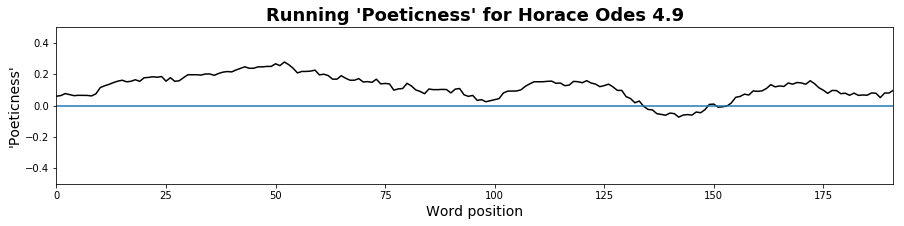

In [101]:
fig = plt.figure()
fig.set_size_inches(15,3)
ax = fig.add_subplot(111)
ax.plot(odes_score_running, color="k")

t =  plt.title('Running \'Poeticness\' for Horace Odes 4.9',fontsize = 18, fontweight = "bold")
#t.set_y(1.05)
fig.subplots_adjust(top=0.85)

ax.axhline(y=0)

#ax.xaxis.labelpad = 10 
#ax.yaxis.labelpad = 10 

ax.set_ylim(-.5,.5)
ax.set_xlim(0,len(odes_score_running)-1)

ax.set_xlabel('Word position', fontsize = 14)
ax.set_ylabel('\'Poeticness\'', fontsize = 14)
plt.show()

In [109]:
list(odes_score_running).index(min(odes_score_running))
" ".join(odes_tokens[142-12:142+13])

'totue tuos patiar labores inpune lolli carpere liuidas obliuiones est animus tibi rerumque prudens et secundis temporibus dubiisque rectus uindex auarae fraudis et abstinens ducentis'

In [126]:
test = "est animus tibi rerumque prudens et secundis temporibus dubiisque rectus".split()
type_df.loc[test]

,prose,verse,poeticness,keyness_scaled
est,3689,3691,0.500136,0.117015
animus,45,61,0.575472,0.000655
tibi,166,1360,0.891219,0.021819
rerumque,7,10,0.588235,0.000085
prudens,11,9,0.450000,0.000495
et,11919,9551,0.444853,0.553912
secundis,20,10,0.333333,0.001596
temporibus,87,12,0.121212,0.013101
dubiisque,1,1,0.500000,0.000032
rectus,1,0,0.000000,0.000193


In [133]:
test = odes_tokens[184:]
type_df.loc[test]

/Users/patrick/Envs/literature-experiments-IJtzxN8Z/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


,prose,verse,poeticness,keyness_scaled
non,4104.0,3031.0,0.424807,0.214050
possidentem,NaN,NaN,NaN,NaN
multa,209.0,352.0,0.627451,0.001187
uocaueris,0.0,1.0,1.000000,0.000035
recte,86.0,1.0,0.011494,0.016286
beatum,0.0,3.0,1.000000,0.000106
rectius,3.0,2.0,0.400000,0.000178
occupat,6.0,47.0,0.886792,0.000723
nomen,110.0,295.0,0.728395,0.000122
beati,1.0,4.0,0.800000,0.000019


In [39]:
def running_poeticness(tokens, window):
    scores = []

    for token in tokens:
        if token in vocab:
            scores.append(type_df.loc[token][2]-.5)
        else:
            scores.append(0)

    return running_mean(scores, window)


def plot_running_poeticness(running_scores, title, length=None):
    
    if not length:
        length = len(running_scores)-1
        
    fig = plt.figure()
    fig.set_size_inches(15,3)
    ax = fig.add_subplot(111)
    ax.plot(running_scores, color="k")

    t =  plt.title(f'Running \'Poeticness\' for {title}',fontsize = 18, fontweight = "bold")
    t.set_y(1.05)
    fig.subplots_adjust(top=0.85)

    ax.axhline(y=0)

    ax.xaxis.labelpad = 10 
    ax.yaxis.labelpad = 10 

    ax.set_ylim(-.5,.5)
    ax.set_xlim(0,length)

    ax.set_xlabel('Word position', fontsize = 14)
    ax.set_ylabel('\'Poeticness\'', fontsize = 14)
    plt.show()

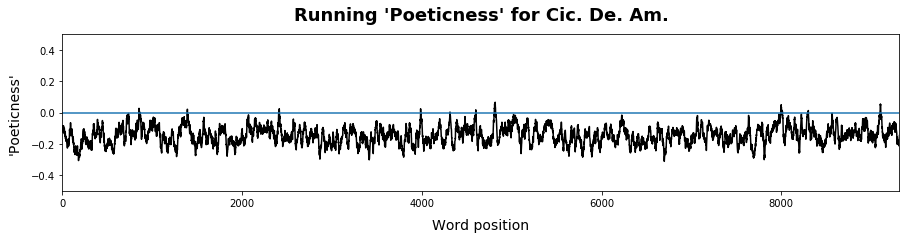

In [40]:
amicitia_tokens = preprocess(latinlibrary.raw('cicero/amic.txt')).split()
running_scores = running_poeticness(amicitia_tokens, 25)
plot_running_poeticness(running_scores, 'Cic. De. Am.')

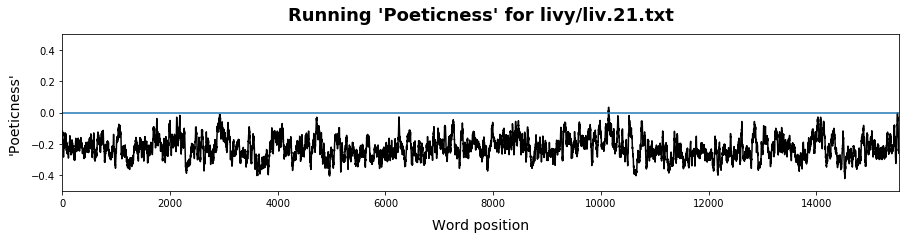

In [41]:
fileid = 'livy/liv.21.txt'
tokens = preprocess(latinlibrary.raw(fileid)).split()
running_scores = running_poeticness(tokens, 25)
plot_running_poeticness(running_scores, fileid)

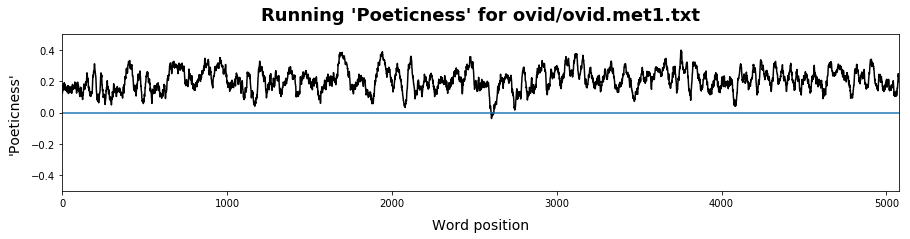

In [42]:
fileid = 'ovid/ovid.met1.txt'
tokens = preprocess(latinlibrary.raw(fileid)).split()
running_scores = running_poeticness(tokens, 25)
plot_running_poeticness(running_scores, fileid)

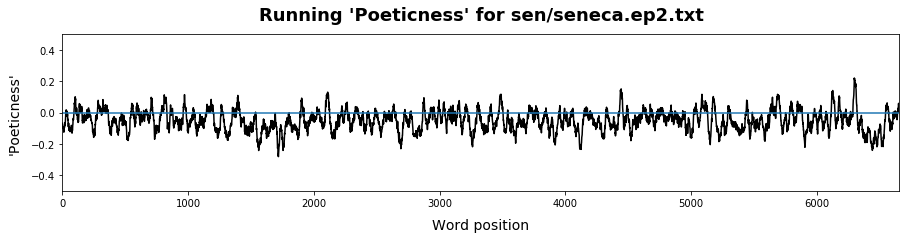

In [43]:
fileid = 'sen/seneca.ep2.txt'
tokens = preprocess(latinlibrary.raw(fileid)).split()
running_scores = running_poeticness(tokens, 25)
plot_running_poeticness(running_scores, fileid)

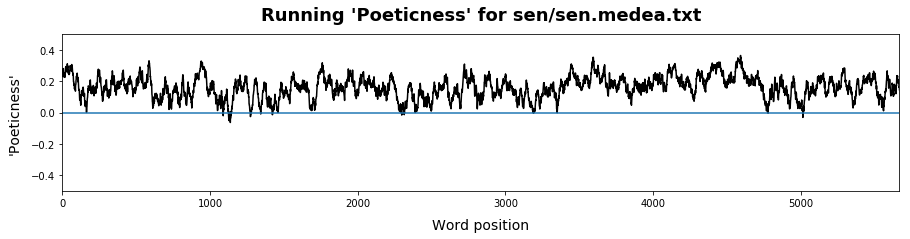

In [44]:
fileid = 'sen/sen.medea.txt'
tokens = preprocess(latinlibrary.raw(fileid)).split()
running_scores = running_poeticness(tokens, 25)
plot_running_poeticness(running_scores, fileid)

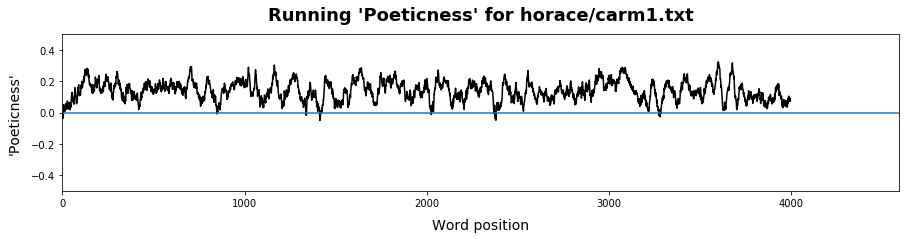

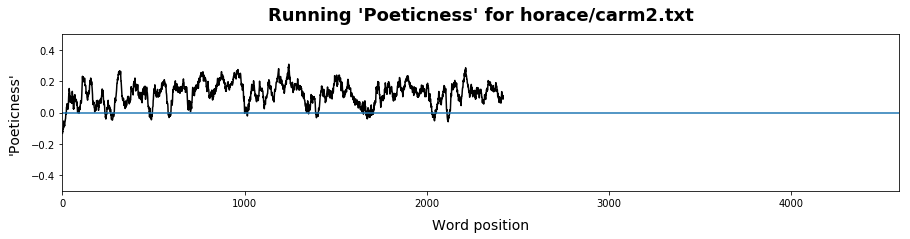

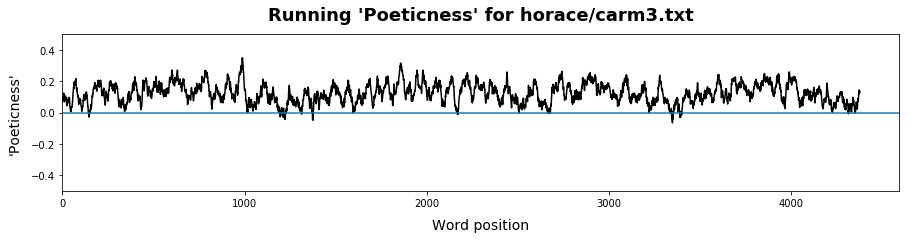

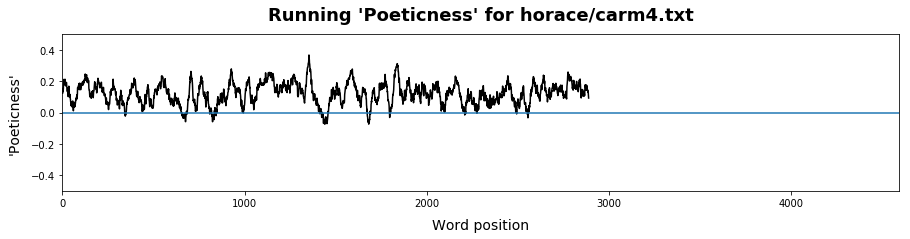

In [45]:
odes = [file for file in latinlibrary.fileids() if 'horace/carm' in file]
odes.remove('horace/carmsaec.txt')

length = max([len(latinlibrary.raw(text).split()) for text in odes])

for book in odes:
    tokens = preprocess(latinlibrary.raw(book)).split()
    running_scores = running_poeticness(tokens, 25)
    plot_running_poeticness(running_scores, book, length=length)

In [46]:
lucan = [file for file in latinlibrary.fileids() if 'lucan/' in file]
lucan = sorted(lucan, key=lambda x : int(" ".join(re.findall(r'\d+',x))))

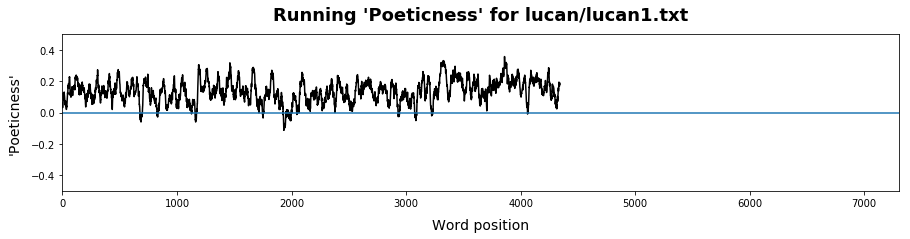

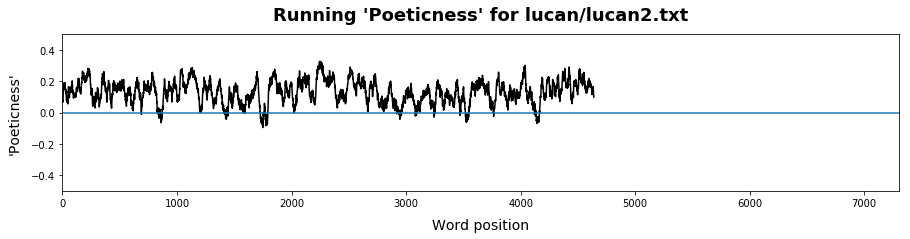

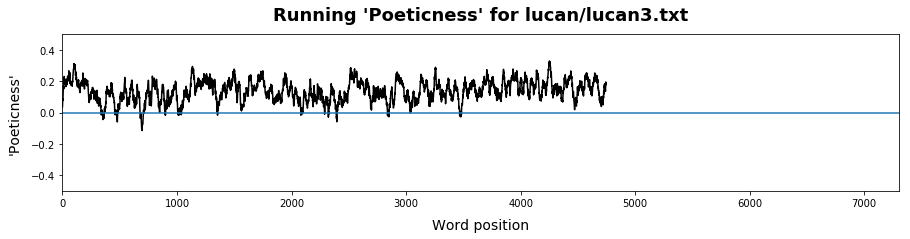

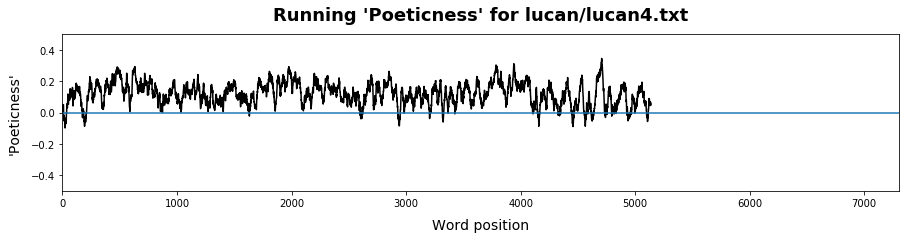

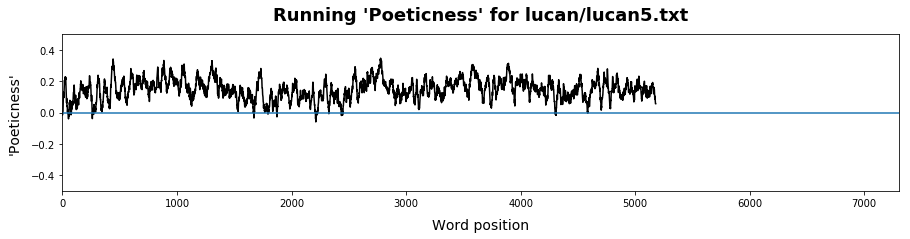

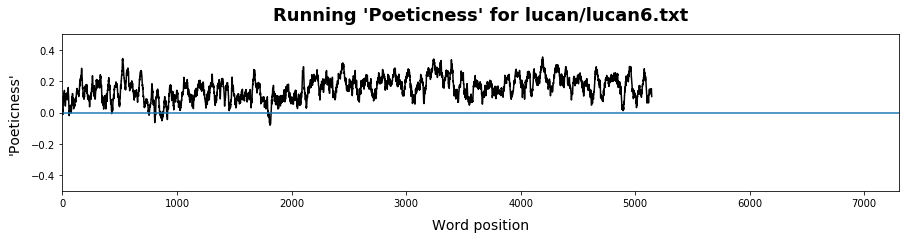

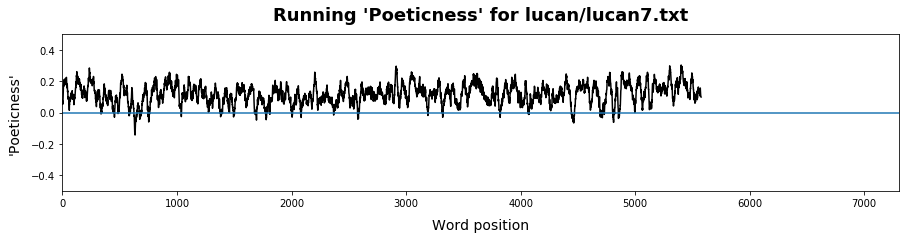

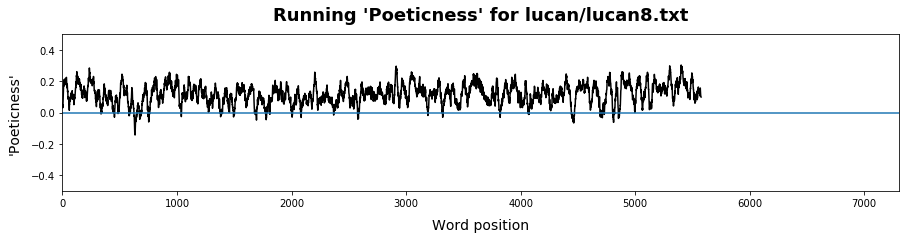

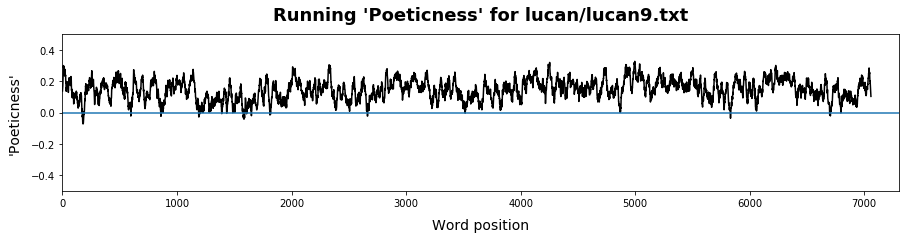

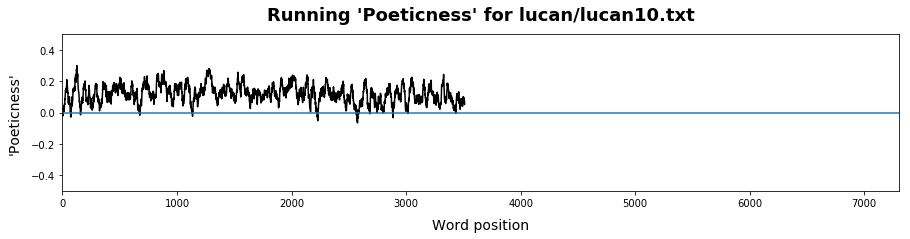

In [47]:
length = max([len(latinlibrary.raw(text).split()) for text in lucan])

for book in lucan:
    tokens = preprocess(latinlibrary.raw(book)).split()
    running_scores = running_poeticness(tokens, 25)
    plot_running_poeticness(running_scores, book, length=length)

## Neutral Words

In [134]:
type_df.loc['sol uir herba'.split()]

,prose,verse,poeticness,keyness_scaled
sol,41,86,0.677165,0.000028
uir,52,100,0.657895,0.000110
herba,13,57,0.814286,0.000356
